In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np 
import warnings
import optuna
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression


from sklearn.metrics import mean_squared_error
from data_downloader import DataDownloader, ClimateDataCleaner, EconomicDataCleaner
from vr_model import VARModel
from sdice_model import SimplifiedDICE, ScenarioDICE
from portfolio import PortfolioOptimizer

In [2]:
# Instancia para limpiar y procesar los datos
climate_data = ClimateDataCleaner('Data/Temperature.csv', 'Data/Drought_Severity.csv', 'Data/CO2_Emissions.xlsx').clean_and_prepare_data()
economic_data = EconomicDataCleaner('Data/GDP.csv', 'Data/TB3MS.csv', 'Data/CPI.csv').clean_and_prepare_data()

# Descarga los datos financieros
downloader = DataDownloader()
gray_a = ['AAPL', 'IBM', 'TSLA', 'GOOG', 'NVDA']
green_a = ['NEE', 'FSLR', 'VWDRY', 'BEP']
assets = gray_a + green_a
benchmark = '^GSPC'
start_date = '2014-11-01'
end_date = '2024-05-31'
rf = .065

asset_prices, benchmark_prices = downloader.download_data(start_date=start_date, 
                                                          end_date=end_date, 
                                                          assets=assets, 
                                                          benchmark=benchmark)

# Fusiona los datos
data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
all_data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
e_eco_data = pd.merge(economic_data, climate_data, on='Date').iloc[:-1]

gray_data = all_data[gray_a]  
green_data = all_data[green_a]
all_data.drop('Date', axis=1, inplace=True)
#e_eco_data.drop('Date', axis=1, inplace=True)

[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  1 of 1 completed


Optimal number of lags: 4


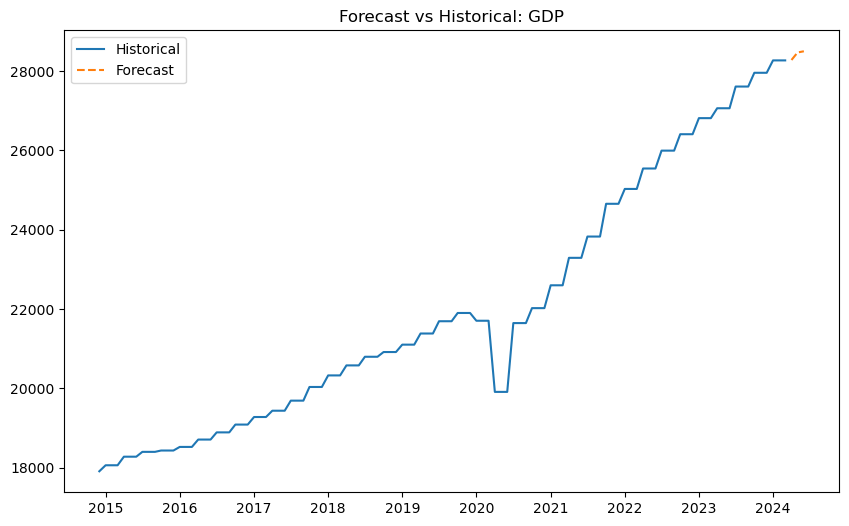

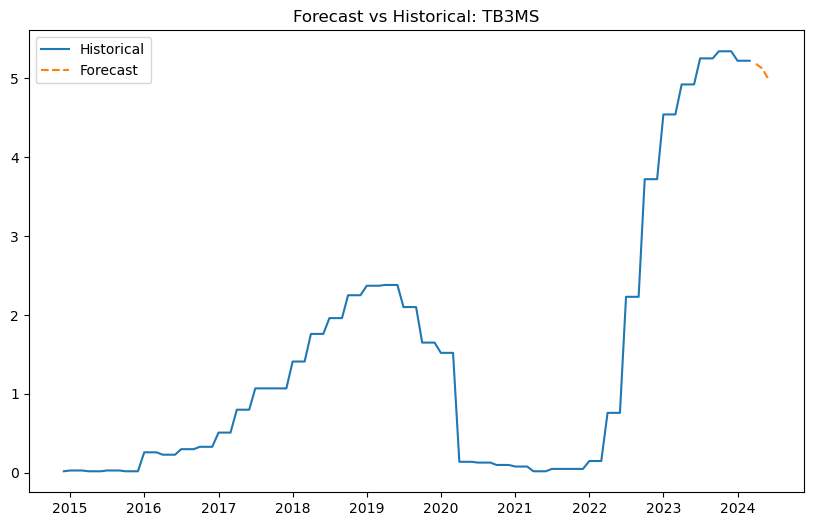

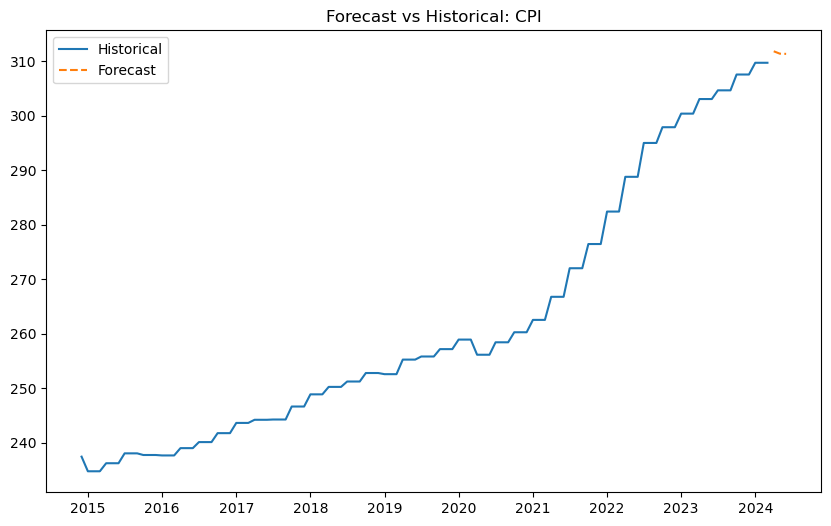

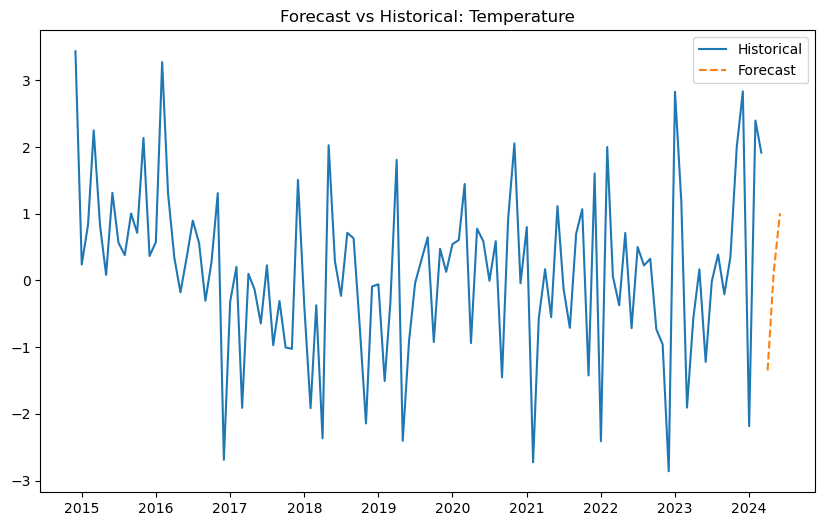

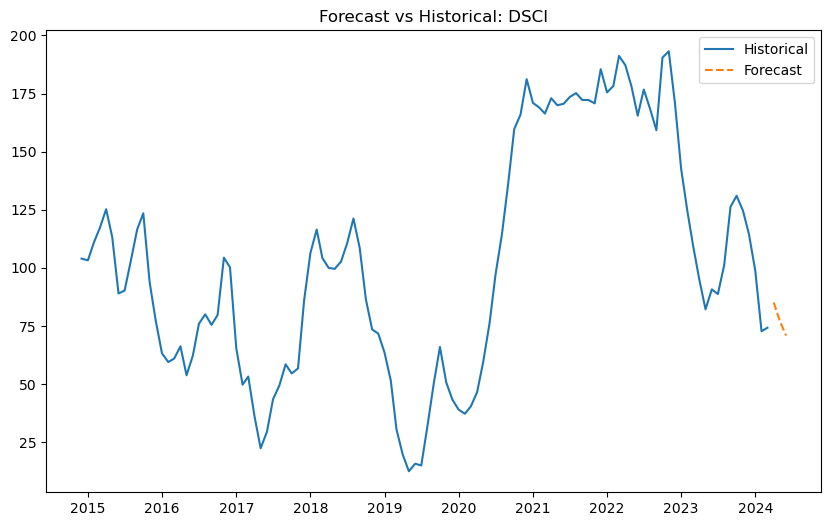

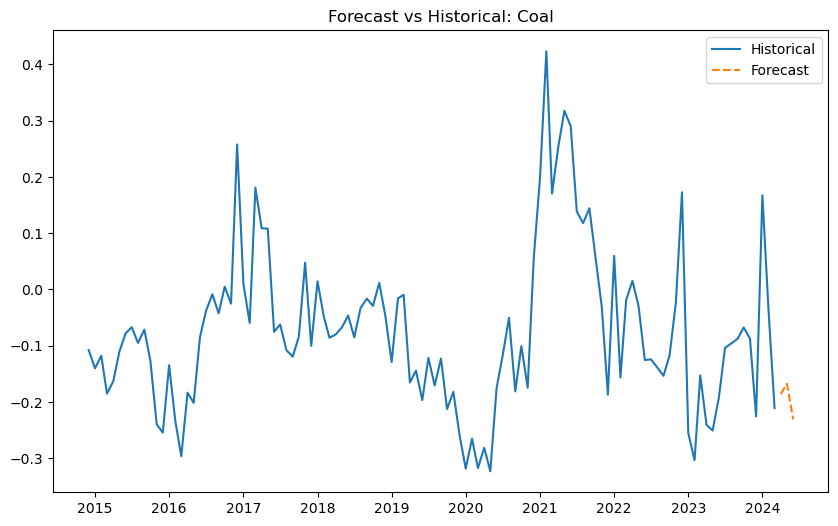

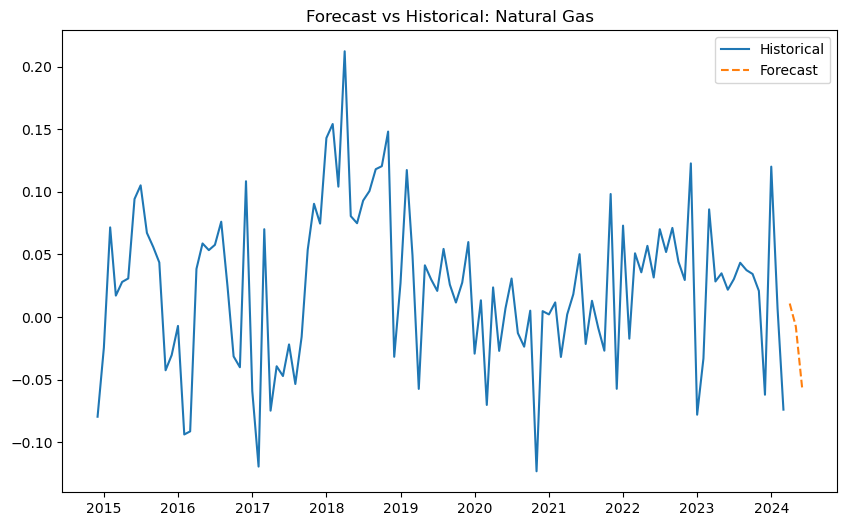

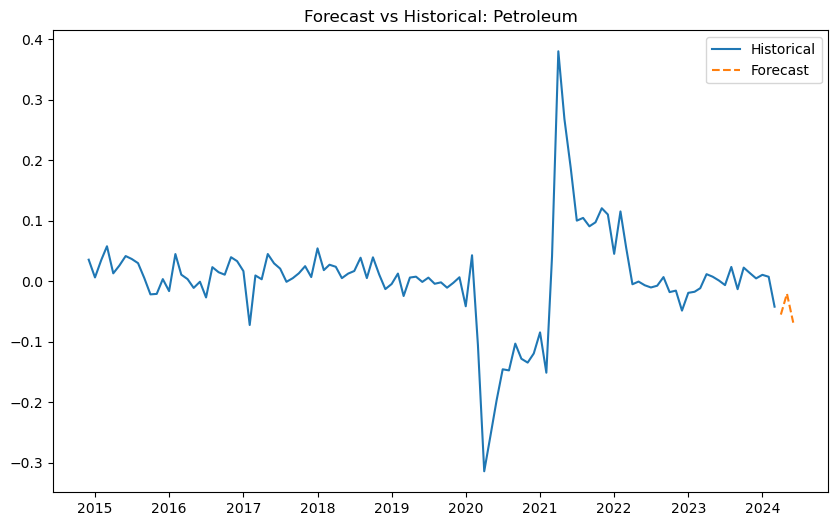

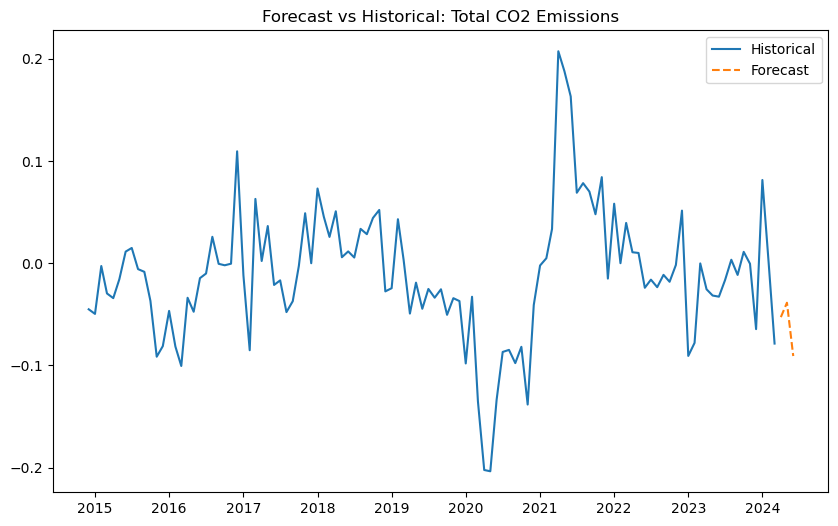

In [3]:
# Inicializar modelo
var_model = VARModel(e_eco_data)

# Optimizar lags con Optuna
var_model.optimize_lags(trials=50)

# Ajustar el modelo con el mejor número de lags
var_model.fit_var(var_model.lag_order)

# Hacer predicciones para los próximos 3 periodos
var_model.plot_predictions(steps=3)

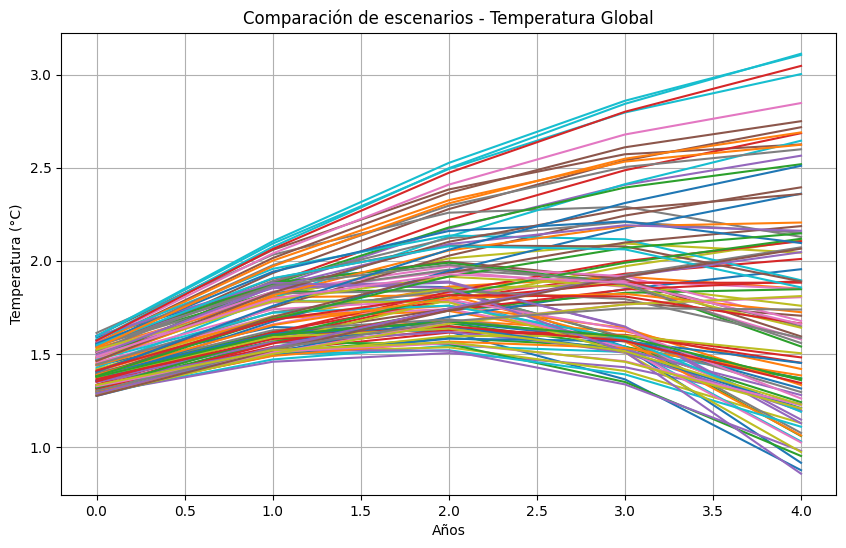

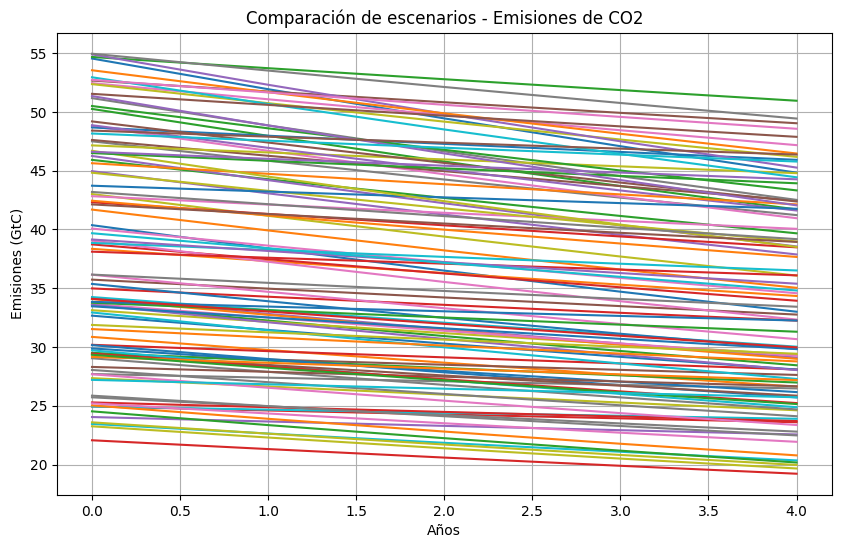

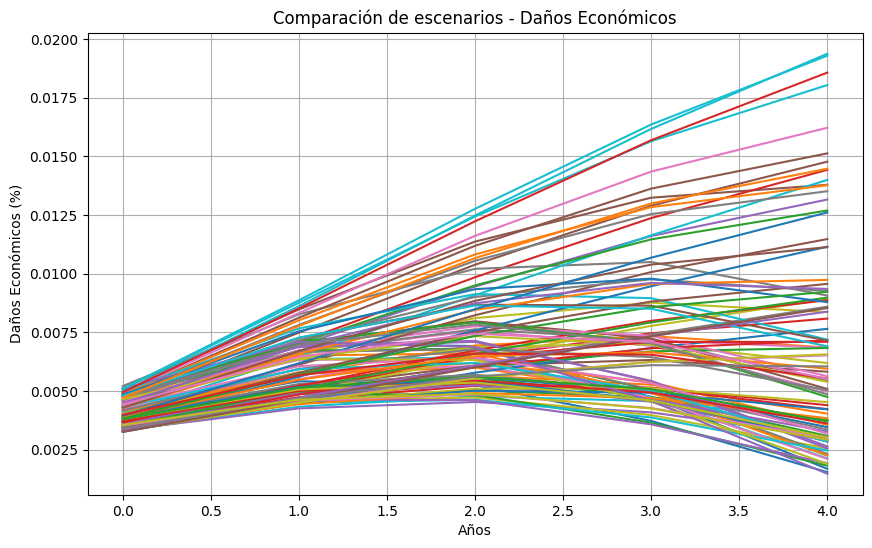

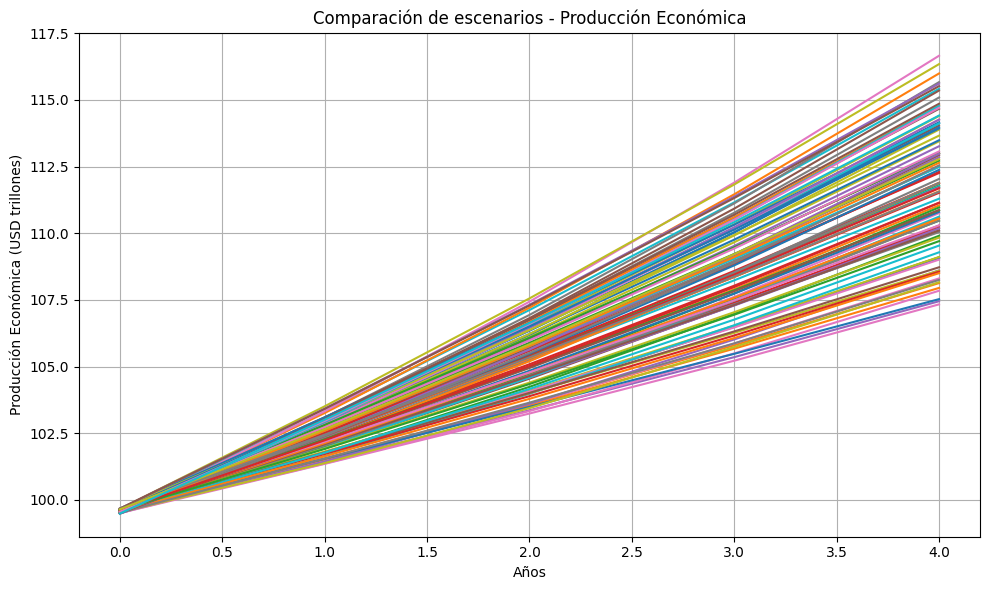

In [17]:
# Instanciar la clase ScenarioDICE
scenario_dice = ScenarioDICE()

# Generar 100 escenarios aleatorios
num_scenarios = 100
scenarios = scenario_dice.generate_random_scenarios(num_scenarios=num_scenarios)

years = 5
results = scenario_dice.simulate_multiple_scenarios(scenarios, years=years)
scenario_dice.plot_scenarios(results, years=years)

In [18]:
optimizer = PortfolioOptimizer(
    asset_prices=asset_prices,
    risk_free_rate=rf,
    benchmark_prices=benchmark_prices
)

optimal_portfolios, portfolios_df = optimizer.optimize_with_multiple_strategies(
    strategies=['sharpe', 'omega', 'sortino'],
    gray_assets=gray_a,
    green_assets=green_a
)

portfolios_df

,weights,metric_score,strategy,green_weight,gray_weight
0,"[0.04, 0.02, 0.15, 0.02, 0.02, 0.02, 0.4, 0.31...",-0.235479,sharpe,0.75,0.25
1,"[0.0, 0.04, 0.03, 0.0, 0.09, 0.01, 0.38, 0.42,...",-0.229350,sharpe,0.75,0.25
2,"[0.14, 0.09, 0.04, 0.01, 0.06, 0.01, 0.57, 0.0...",-0.239326,sharpe,0.75,0.25
3,"[0.01, 0.1, 0.03, 0.06, 0.03, 0.01, 0.44, 0.3,...",-0.240599,sharpe,0.75,0.25
4,"[0.05, 0.01, 0.03, 0.02, 0.01, 0.1, 0.54, 0.12...",-0.243638,sharpe,0.75,0.25
5,"[0.04, 0.02, 0.02, 0.15, 0.02, 0.02, 0.69, 0.0...",3.185905,omega,0.75,0.25
6,"[0.02, 0.0, 0.1, 0.13, 0.01, 0.19, 0.37, 0.08,...",3.444781,omega,0.75,0.25
7,"[0.03, 0.01, 0.08, 0.06, 0.12, 0.2, 0.37, 0.13...",3.422480,omega,0.75,0.25
8,"[0.08, 0.01, 0.09, 0.07, 0.06, 0.24, 0.34, 0.0...",3.414617,omega,0.75,0.25
9,"[0.05, 0.01, 0.09, 0.04, 0.06, 0.28, 0.33, 0.1...",3.398420,omega,0.75,0.25


In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

economic_climate_vars = ['Temperature', 'DSCI', 'Coal', 'Natural Gas', 'Petroleum',
                         'Total CO2 Emissions', 'GDP', 'TB3MS', 'CPI']

aligned_data = all_data[economic_climate_vars].dropna()

aligned_data = aligned_data.loc[all_data.index]

# Inicializa un dataframe para almacenar las betas
betas_df = pd.DataFrame(index=gray_a + green_a, columns=economic_climate_vars)

# Calcula las betas de cada activo respecto a las demás variables
for asset in gray_a + green_a:
    # Prepara las variables dependientes e independientes
    X = aligned_data.values  # Variables económicas y climáticas
    y = all_data[asset].values  # Retornos del activo (ya están en all_data)

    # Ajusta un modelo de regresión lineal
    model = LinearRegression()
    model.fit(X, y)

    # Almacena las betas en el dataframe
    betas_df.loc[asset] = model.coef_

betas_df



,Temperature,DSCI,Coal,Natural Gas,Petroleum,Total CO2 Emissions,GDP,TB3MS,CPI
AAPL,0.008777,-0.000051,-0.442633,-0.56396,-1.031284,1.926665,0.000017,-0.005865,-0.002418
IBM,-0.004645,0.000164,0.209146,0.137489,0.415655,-0.954295,0.000003,0.008439,-0.000496
TSLA,0.025597,-0.000595,-0.850727,-0.97392,-2.026972,3.391758,0.000042,-0.044556,-0.003488
GOOG,0.009861,-0.000205,0.371654,0.335359,0.408169,-1.184453,0.00001,0.001867,-0.001055
NVDA,0.026794,-0.000637,-0.512605,-0.831173,-1.243105,2.975887,-0.000043,-0.006814,0.006638
NEE,0.000178,-0.000103,-0.299851,-0.380283,-0.54467,1.139701,0.000023,-0.00609,-0.00316
FSLR,0.0218,-0.000015,-0.530892,-0.704204,-1.469721,2.635884,-0.000026,-0.013185,0.004077
VWDRY,0.009615,0.000775,-0.001026,-0.236739,-0.320119,0.039238,-0.000008,0.026699,-0.001457
BEP,0.003069,-0.00008,-0.290105,-0.409745,-0.624588,0.973063,0.00004,-0.004831,-0.005496


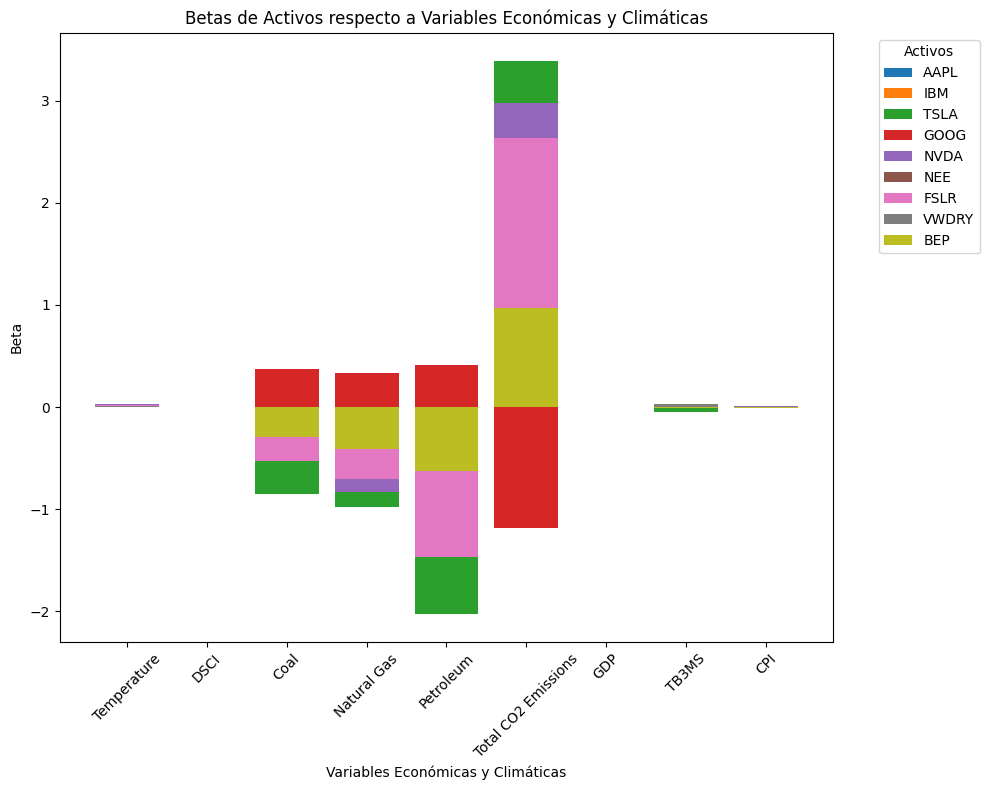

In [21]:
import matplotlib.pyplot as plt

# Creamos una figura y subplots
fig, ax = plt.subplots(figsize=(10, 8))

# Para cada activo, graficamos las betas respecto a las variables
for asset in betas_df.index:
    ax.bar(betas_df.columns, betas_df.loc[asset], label=asset)

# Etiquetas y títulos
ax.set_title('Betas de Activos respecto a Variables Económicas y Climáticas')
ax.set_xlabel('Variables Económicas y Climáticas')
ax.set_ylabel('Beta')
ax.legend(title="Activos", bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotar etiquetas del eje x para mejor visibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [20]:
# Buscar el portafolio con el mejor score
best_portfolio = portfolios_df.loc[portfolios_df['score'].idxmax()]

# Calcular el retorno promedio del mejor portafolio
average_return = np.mean(best_portfolio['adjusted_return'])

# Imprimir el mejor portafolio con su retorno promedio
print(f"\nRetorno promedio del mejor portafolio: {average_return:.4f}")
best_portfolio


KeyError: 'score'